In [1]:
#!pip install statannotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp  

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
# display(results_df.sample(3))

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDownOnlyLast.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown1e-6.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp.py'] ['Top Down 1e-1', 'Bottom Up (only last)', 'Top Down (only last)', 'Bottom Up 1e-6', 'Bottom Up 1e-2', 'Bottom Up 1e-10', 'Top Down 1e-0', 'Bottom Up 1e-0', 'Top Down 1e-4', 'Top Down 1e-6', 'Without simplify', 'Bottom Up 1e-4', 'Top Down', 'Top Down 1e-10', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up']
(539, 14)
['Without simplify' 'Top Down' 'Bottom U

In [2]:
# Filter the DataFrame
filtered_df = results_df[results_df['dataset'] == 'Yacht']

# Group by 'model' and find the index of the minimum 'size' for each 'model'
min_indices = filtered_df.groupby('model')['size'].idxmin()

# Select the corresponding rows from the DataFrame
smallest_sizes_df = filtered_df.loc[min_indices]

expressions = smallest_sizes_df[['model', 'representation', 'test_mse', 'size']]
expressions

,model,representation,test_mse,size
516,Bottom Up,"square(exp(subtract(add(-1.496589547973727, multiply(x_5, 8.991253285685834)), x_1)))",1.980159,9
502,Top Down,"expm1(tan(add(sqrt(subtract(x_5, minimum(0.25001422348674396, x_5))), sqrt(sin(sqrtabs(subtract(x_5, -0.3246428353332059)))))))",6.364592,15
449,Without simplify,"expm1(sqrt(square(add(expm1(add(1.3663211074060027, multiply(x_1, -4.102438322120827))), multiply(25.044747265751315, log1p(square(x_5)))))))",2.086483,15


In [3]:
from sympy import *
import re

func_dict = {
    'multiply': '*',
    'subtract': '-',
    'add3': '+',
    'add4': '+',
    'mul3': '*',
    'mul4': '*',
    'cdiv': '/',
    'add': '+'
}

func_arity = {
    'multiply': 2,
    'subtract': 2,
    'add3': 3,
    'add4': 4,
    'mul3': 3,
    'mul4': 4,
    'cdiv': 2,
    'add': 2,
    'maximum' : 2,
    'minimum' : 2,
    'max' : 2,
    'min' : 2,
    'sin' : 1,
    'cos' : 1,
    'tan' : 1,
    'arcsin' : 1,
    'arccos' : 1,
    'arctan' : 1,
    'sqrtabs' : 1,
    'sqrt' : 1,
    'abs' : 1,
    'log1p'   : 1,
    'log'     : 1,
    'exp'     : 1,
    'expm1'   : 1,
    'square'  : 1,
    'absolute' : 1
}

def pretify_expr(string):
    # Breaking down into a list of symbols. handliilng sqrtabs and max/minimum
    ind = string.replace('sqrtabs','sqrt').replace('imum','') \
                .replace(' ','').replace(')','').replace('(',',').split(',')

    new_string = ""
    stack = []
    for node in ind:
        stack.append((node, []))
        while len(stack[-1][1]) == func_arity.get(stack[-1][0], 0):

            prim, args = stack.pop()
            new_string = prim
            if prim in func_dict.keys():
                new_string = '(' + func_dict[prim].join(args) + ')'
            elif not prim.startswith('x_'):
                try:
                    float(prim)
                except:
                    new_string = prim + '(' + args[0] + ')'
                
            if len(stack) == 0:
                break

            stack[-1][1].append(new_string)

    return new_string

def count_float_occurrences(s):
   pattern = r'\d+\.\d+' # Matches sequences of digits followed by a dot and more digits
   matches = re.findall(pattern, s)
   return len(matches)

def count_occurrences(s, sub):
   res = 0
   for i in range(len(s)):
       if s[i:i+len(sub)] == sub:
           res += 1
   return res

funcs = [
    '-', '+', '+', '/', 'maximum', 'minimum', 'max', 'min', 'sin', 'cos', 'tan', 
    'arcsin', 'arccos', 'arctan', 'sqrtabs', 'expm1',
    'sqrt', 'abs', 'log1p', 'log', 'exp', 'square', 'absolute']

In [4]:
new_columns = []

for i, col in results_df.iterrows():
    sympy_compatible = str(pretify_expr(col['representation']))
    try:
        sympy_simplified = str(simplify(sympy_compatible))
    except Exception as e:
        print(e)
        continue
    # stats: number of functions, constants, variables, and total number ofnodes
    n_features_before  = count_occurrences(sympy_compatible, "x_")
    n_constants_before = count_float_occurrences(sympy_compatible)
    n_functions_before = sum([count_occurrences(sympy_compatible, f)
                              for f in funcs])

    n_features_after  = count_occurrences(sympy_simplified, "x_")
    n_constants_after = count_float_occurrences(sympy_simplified)
    n_functions_after = sum([count_occurrences(sympy_simplified, f)
                             for f in funcs])

    new_columns.append([
        n_features_before-n_features_after,
        n_constants_before-n_constants_after,
        n_functions_before-n_functions_after,
        (n_features_before+n_constants_before+n_functions_before)-\
        (n_features_after+n_constants_after+n_functions_after),
    ])

deltas_df = pd.DataFrame(new_columns, columns=['features simplified',
                                               'constants simplified',
                                               'functions simplified',
                                               'nodes simplified'])

results_df = pd.concat([results_df, deltas_df], axis=1 )
results_df.sample(3)

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth,features simplified,constants simplified,functions simplified,nodes simplified
416,Top Down,Housing,0,9540,2158.906435,01-30-2024 00:34:27,0.774640,0.730940,16.976454,21.368008,"subtract(maximum(multiply(add(x_5, -2.018243549487597), subtract(multiply(maximum(0.23620597952891123, subtract(x_0, x_7)), x_3), -8.617357036460257)), 38.30703476048185), add(x_10, add(multiply(log(sqrt(add(x_5, -3.1414210968111766))), subtract(x_12, 16.766963535193156)), sqrtabs(multiply(x_4, add(x_0, x_7))))))",34,355,7,0,-1,4,3
334,Bottom Up,Energy Heating,0,13352,2971.234003,01-29-2024 23:42:53,0.964748,0.957263,3.528292,4.247981,"add(subtract(add(multiply(multiply(tan(cos(x_2)), x_1), -0.010966979485709658), sqrt(multiply(414.1070411104783, x_6))), -27.425293588937777), multiply(subtract(cdiv(arctan(sqrtabs(x_6)), tan(cos(multiply(x_2, 0.11089944666004145)))), subtract(x_4, add(-0.5652804486762022, log1p(x_3)))), multiply(multiply(subtract(sqrtabs(multiply(x_2, 0.11076341930144872)), x_4), multiply(multiply(2.07741521338993e-08, x_1), subtract(x_3, x_1))), x_1)))",48,410,7,-1,-2,-3,-6
162,Bottom Up,Concrete,0,9540,4934.963565,01-30-2024 00:06:44,0.826753,0.799898,42.187940,50.522369,"subtract(add(minimum(add(-4.3643544888472965, add(sqrt(add(x_1, 354.18503271808265)), x_7)), subtract(add(minimum(x_2, 12.783679896393402), subtract(12.172186464494546, multiply(-0.31459758617280603, x_7))), multiply(x_1, -0.13617713413842883))), multiply(x_3, subtract(subtract(-0.19546079313875858, square(multiply(0.0016298620873075416, x_7))), arcsin(cdiv(-0.20246590413816237, x_7))))), multiply(subtract(subtract(0.09873059592910377, square(multiply(0.0010311074230530493, x_7))), multiply(subtract(0.19262650706294568, multiply(0.0004749827268956391, x_7)), arctan(log1p(x_7)))), x_0))",55,509,7,0,-1,0,-1


[[<Axes: ylabel='features simplified'>]]
Without simplify greater TtestResult(statistic=-2.2703245893974238, pvalue=0.9878101527719061, df=179)
Without simplify less TtestResult(statistic=-2.2703245893974238, pvalue=0.012189847228093922, df=179)
Top Down greater TtestResult(statistic=-3.885465007549209, pvalue=0.9999280465569733, df=178)
Top Down less TtestResult(statistic=-3.885465007549209, pvalue=7.195344302669293e-05, df=178)
Bottom Up greater TtestResult(statistic=-4.742373313144594, pvalue=0.9999978507855364, df=179)
Bottom Up less TtestResult(statistic=-4.742373313144594, pvalue=2.1492144636003437e-06, df=179)


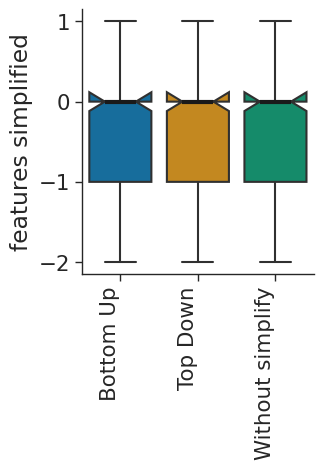

[[<Axes: ylabel='constants simplified'>]]
Without simplify greater TtestResult(statistic=-4.894670718057268, pvalue=0.9999989060419721, df=179)
Without simplify less TtestResult(statistic=-4.894670718057268, pvalue=1.093958027962024e-06, df=179)
Top Down greater TtestResult(statistic=-6.128949697153983, pvalue=0.9999999972278761, df=178)
Top Down less TtestResult(statistic=-6.128949697153983, pvalue=2.772123802385783e-09, df=178)
Bottom Up greater TtestResult(statistic=-4.6060952690988906, pvalue=0.9999961170672828, df=179)
Bottom Up less TtestResult(statistic=-4.6060952690988906, pvalue=3.8829327172495525e-06, df=179)


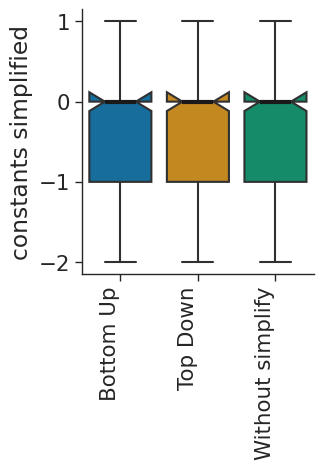

[[<Axes: ylabel='functions simplified'>]]
Without simplify greater TtestResult(statistic=8.909843747296415, pvalue=2.8659147655397933e-16, df=179)
Without simplify less TtestResult(statistic=8.909843747296415, pvalue=0.9999999999999998, df=179)
Top Down greater TtestResult(statistic=8.515910945074635, pvalue=3.379390215963305e-15, df=178)
Top Down less TtestResult(statistic=8.515910945074635, pvalue=0.9999999999999966, df=178)
Bottom Up greater TtestResult(statistic=7.288681347588488, pvalue=4.8372827946134844e-12, df=179)
Bottom Up less TtestResult(statistic=7.288681347588488, pvalue=0.9999999999951628, df=179)


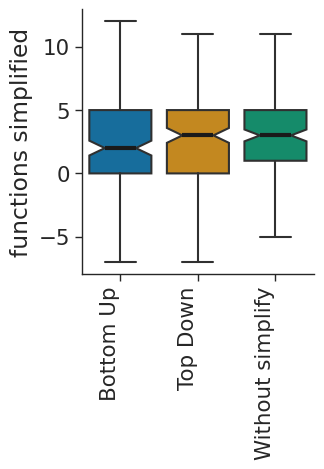

[[<Axes: ylabel='nodes simplified'>]]
Without simplify greater TtestResult(statistic=4.328552170425187, pvalue=1.2464475212220355e-05, df=179)
Without simplify less TtestResult(statistic=4.328552170425187, pvalue=0.9999875355247878, df=179)
Top Down greater TtestResult(statistic=3.6365621447427317, pvalue=0.00018080498111304767, df=178)
Top Down less TtestResult(statistic=3.6365621447427317, pvalue=0.9998191950188869, df=178)
Bottom Up greater TtestResult(statistic=2.479800201335323, pvalue=0.007035072423323896, df=179)
Bottom Up less TtestResult(statistic=2.479800201335323, pvalue=0.9929649275766761, df=179)


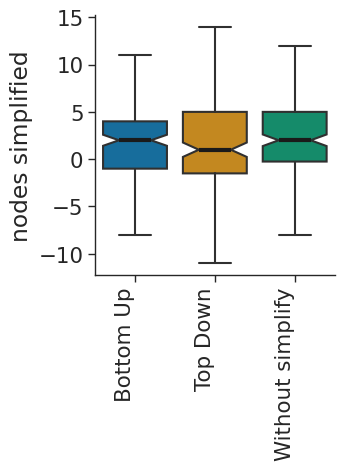

In [5]:
for yaxis in deltas_df.columns:
    g=sns.catplot( data=results_df, y=yaxis, x='model', 
        legend_out=False, aspect=0.75,
        order = order, # The first is Baseline
        **{**boxplot_kwargs, **{'showfliers':False}}, sharey=False
    )

    # g.set(yscale="log")
    g.set_titles("{col_name}").set_axis_labels("", yaxis)

    print(g.axes)

    # iterate through each subplot / Facet>

    for tick in g.axes[0][0].get_xticklabels():
        tick.set(rotation=90, ha="right")

    for model in results_df['model'].unique():
        print(model, 'greater',
              ttest_1samp(
                  (results_df[results_df['model']==model])[yaxis].dropna(),
                  popmean=0.0, alternative='greater'
              )
        )
        print(model, 'less',
              ttest_1samp(
                  (results_df[results_df['model']==model])[yaxis].dropna(),
                  popmean=0.0, alternative='less'
              )
        )

    if False:
        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df['model'].unique()
                    if l != 'Without simplify']

        annotator = Annotator(
            plot_ax, pairs, data=results_df,
            x='model', y=yaxis,
            order=order)
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()